In [1]:
from credit import interp as inty

import xarray as xr 
import glob 
import matplotlib.pyplot as plt
from scipy.signal import detrend

import numpy as np
import copy
import os 
import sys 
import matplotlib.pyplot as plt 
import glob
import pickle

import cartopy.crs as ccrs

from sklearn.preprocessing import QuantileTransformer
from functools import lru_cache

import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

from scipy.optimize import linear_sum_assignment
from PIL import Image
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import pandas as pd
from eofs.xarray import Eof
from scipy.ndimage import gaussian_filter


## Think about adding dask

## Open Necessary Datasets

In [2]:
%%time
model_level_file = '/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.statics_1.0deg_32levs_latlon_F32_hyai_fixed.nc'
DSml = xr.open_dataset(model_level_file)
DSml['level'] = np.arange(0,32)
DSml['ilev'] = np.arange(0,33)
DSml['a_model'] = DSml['hyai']
DSml['b_model'] = DSml['hybi']
DSml.to_netcdf('/glade/work/wchapman/miles_branchs/CESM_physics_multigpu/credit/metadata/CESM_Lev_Info.nc')

#grab emulator data:
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-01T00Z/1D/averaged_UVTQtotPSPRECTTREFHT*'))
print('... opening model run ...')
DSs = xr.open_mfdataset(FNS[0])
DSs['PHIS'] = DSml['PHIS']

... opening model run ...


In [6]:
%%time
skip_cell = True

if skip_cell:
    print('skipping this cell')
else: 
    FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-01T00Z/1D/averaged_UVTQtotPSPRECTTREFHT*'))
    
    fp_out = '/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-01T00Z/1MS/'
    
    for fn in FNS:
        print(fn)
        DSs = xr.open_mfdataset(fn)
        DSs['PHIS'] = DSml['PHIS']
        fn_out = f'{fp_out}/{str(DSs["time"].values)[2:9]}_Pressure_Levels.nc'
    
        if os.path.exists(fn_out):
            print(f'{fn_out} file exists... skipping')
            continue 
        
        interp_fields = ('U', 'V', 'T', 'Qtot')
        q_var = 'Qtot'
        surface_pressure_var = 'PS'
        surface_geopotential_var = 'PHIS'
        levs = np.array([200., 500., 700., 850.])
        model_level_file = '/glade/work/wchapman/miles_branchs/CESM_physics_multigpu/credit/metadata/CESM_Lev_Info.nc'
        DSdo = inty.full_state_pressure_interpolation(DSs, model_level_file = model_level_file,q_var = q_var, interp_fields = interp_fields, 
                                               surface_pressure_var = surface_pressure_var,surface_geopotential_var=surface_geopotential_var,pressure_levels = levs)
        
        ds_avg = DSdo.resample(time='1MS').mean()
        print(f'saved: {fn_out}')
        ds_avg.to_netcdf(fn_out)

skipping this cell
CPU times: user 30 μs, sys: 0 ns, total: 30 μs
Wall time: 33.4 μs


## CESM

In [3]:
%%time
skip_cell = True

if skip_cell:
    print('skipping this cell')
else:
    fp_out = '/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00223_b/1979-01-01T00Z/1MS/'
    conc = []
    for yryr in range(1979,2009):
        print(f'doing {yryr}')
        conc = xr.open_zarr(f'/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate_{yryr}_ERA5scaled_F32_Qtot.zarr')
        # conc.append(DSdo_1)
    
        print('... resampling and loading ....')
        DSzarr1 = conc[['U', 'V', 'T', 'Qtot','PS']]
        DSzarr1['level']=DSs['level']
        print('... resampling and loading ....')
        DSzarr1 = DSzarr1.resample(time='1D').mean().load()
        print('... resampling and loading ....')
        DSzarr1['PHIS'] = DSml['PHIS']
    
        date_range = pd.date_range(start=f'{yryr}-01', end=f'{yryr}-12', freq='1MS')
    
        for bebop in date_range:
            ddo = DSzarr1.sel(time=str(bebop)[0:7])
    
            fn_out = f'{fp_out}/CESM_{str(bebop)[0:7]}_Pressure_Levels.nc'
        
            if os.path.exists(fn_out):
                print(f'{fn_out} file exists... skipping')
                continue 
            
            interp_fields = ('U', 'V', 'T', 'Qtot')
            q_var = 'Qtot'
            surface_pressure_var = 'PS'
            surface_geopotential_var = 'PHIS'
            levs = np.array([200., 500., 700., 850.])
            model_level_file = '/glade/work/wchapman/miles_branchs/CESM_physics_multigpu/credit/metadata/CESM_Lev_Info.nc'
            DSdo = inty.full_state_pressure_interpolation(ddo, model_level_file = model_level_file,q_var = q_var, interp_fields = interp_fields, 
                                                   surface_pressure_var = surface_pressure_var,surface_geopotential_var=surface_geopotential_var,pressure_levels = levs)
            
            ds_avg = DSdo.resample(time='1MS').mean()
            print(f'saved: {fn_out}')
            ds_avg.to_netcdf(fn_out)


skipping this cell
CPU times: user 68 μs, sys: 0 ns, total: 68 μs
Wall time: 73.4 μs


## Modes:

In [4]:
%%time
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00223_b/1979-01-01T00Z/1MS//CESM_*_Pressure_Levels.nc'))
DSall_CESM = xr.open_mfdataset(FNS)
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-01T00Z_OG/1MS/????-??_Pressure_Levels.nc'))
DSall = xr.open_mfdataset(FNS)

CPU times: user 6.09 s, sys: 656 ms, total: 6.75 s
Wall time: 7.01 s


one
two


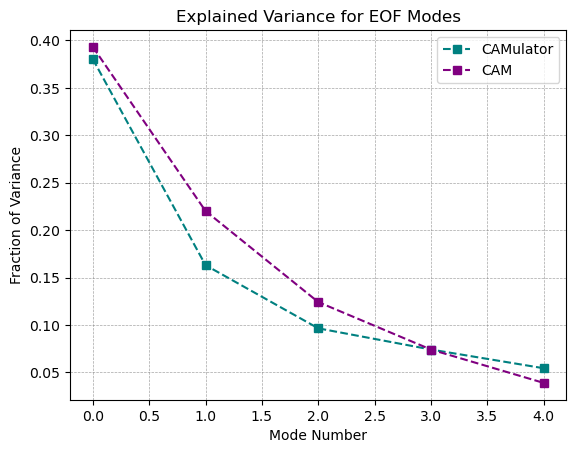

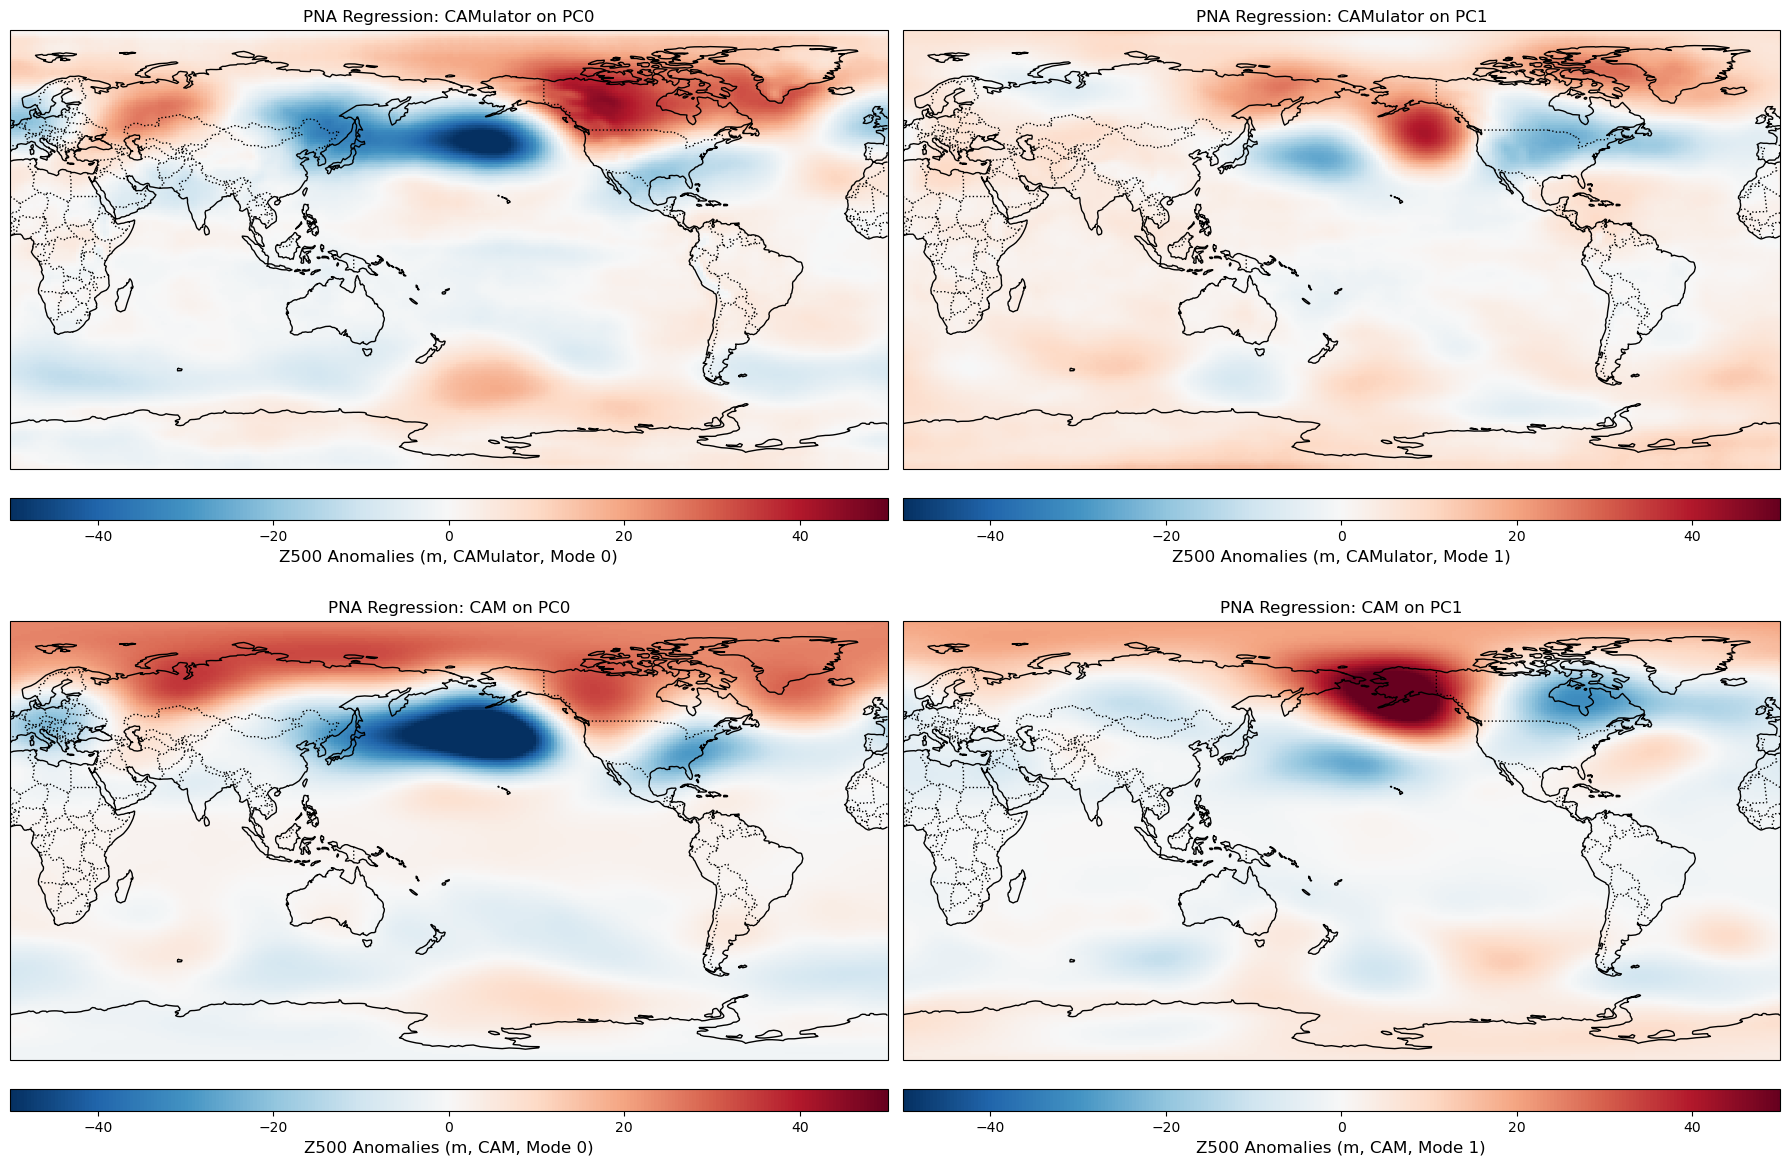

In [5]:
# import numpy as np
# import matplotlib.pyplot as plt
# from eofs.standard import Eof  # Ensure eofs library is installed
# from scipy.ndimage import gaussian_filter

mons = [12, 1, 2]  # Months for DJF

# Step 1: Select the winter months (Dec, Jan, Feb) and spatial slice for DSall
print('one')
# Group data into winter seasons by averaging over Dec-Jan-Feb for each year
# Latitude weighting is applied to capture spherical influences
DS_winter = DSall.resample(time='QS-DEC').mean().where(DSall['time'].dt.month.isin(mons), drop=True).sel(latitude=slice(20, 85), longitude=slice(120, 300))

# Extract the geopotential height at 500 hPa and remove the time mean
DSwtot = DS_winter['Z_PRES'].sel(pressure=500).load()
DSwtota = DSwtot - DSwtot.mean('time')

# Step 2: Calculate weights based on cosine of latitude
coslat = np.cos(np.deg2rad(DSwtota.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]  # Expand dimensions to align with dataset

# Step 3: Perform EOF analysis for PNA extraction
# EOF patterns are computed for the domain (20-85°N, 120°E-120°W)
solver1 = Eof(DSwtota, weights=wgts)  # Create an EOF solver for the dataset
eof1 = solver1.eofsAsCorrelation(neofs=3)  # Extract the first 3 EOFs as correlations
pc1 = solver1.pcs(npcs=3, pcscaling=1)  # Get the first 3 PCs with scaling

# Step 4: Repeat the above for the CESM dataset
print('two')
DS_winter_CESM = DSall_CESM.resample(time='QS-DEC').mean().where(DSall_CESM['time'].dt.month.isin(mons), drop=True).sel(latitude=slice(20, 85), longitude=slice(120, 300))

DSwtot_CESM = DS_winter_CESM['Z_PRES'].sel(pressure=500).load()
DSwtota_CESM = DSwtot_CESM - DSwtot_CESM.mean('time')

coslat = np.cos(np.deg2rad(DSwtota_CESM.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]

solver2 = Eof(DSwtota_CESM, weights=wgts)
eof2 = solver2.eofsAsCorrelation(neofs=3)
pc2 = solver2.pcs(npcs=3, pcscaling=1)

# Step 5: Plot explained variance for both datasets
solver1.varianceFraction(neigs=5).plot(color='teal', linestyle='--', marker='s', label='CAMulator')
solver2.varianceFraction(neigs=5).plot(color='purple', linestyle='--', marker='s', label='CAM')

plt.title("Explained Variance for EOF Modes")
plt.xlabel("Mode Number")
plt.ylabel("Fraction of Variance")
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

# Step 6: Regression of DS_winter and DS_winter_CESM on PC1 (Modes 0, 1)
fig, axes = plt.subplots(2, 2, figsize=(18, 12), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)})

for mode in range(2):
    # Flatten spatial dimensions for regression
    DS_winter_flat = DSall.resample(time='QS-DEC').mean().where(DSall['time'].dt.month.isin(mons), drop=True).stack(space=("latitude", "longitude"))['Z_PRES'].sel(pressure=500)
    DS_winter_CESM_flat = DSall_CESM.resample(time='QS-DEC').mean().where(DSall_CESM['time'].dt.month.isin(mons), drop=True).stack(space=("latitude", "longitude"))['Z_PRES'].sel(pressure=500)

    # Compute regression coefficients for DS_winter and DS_winter_CESM
    regression_coeffs_ds = np.dot(DS_winter_flat.values.T, pc1[:, mode]) / np.dot(pc1[:, mode], pc1[:, mode])
    regression_coeffs_cesm = np.dot(DS_winter_CESM_flat.values.T, pc2[:, mode]) / np.dot(pc2[:, mode], pc2[:, mode])

    # Reshape coefficients back to spatial dimensions
    regression_map_ds = regression_coeffs_ds.reshape(DSall["latitude"].size, DSall["longitude"].size)
    regression_map_cesm = regression_coeffs_cesm.reshape(DSall_CESM["latitude"].size, DSall_CESM["longitude"].size)

    # Ensure EOF patterns have the same sign by correlating regression maps
    correlation = np.corrcoef(regression_map_ds.flatten(), regression_map_cesm.flatten())[0, 1]
    if correlation < 0:
        regression_map_cesm = -regression_map_cesm

    # Apply spatial smoothing using Gaussian filter
    smoothed_map_ds = gaussian_filter(regression_map_ds, sigma=1)  # Adjust sigma for smoothing level
    smoothed_map_cesm = gaussian_filter(regression_map_cesm, sigma=1)

    # Plot regression map for DS_winter
    ax = axes[0, mode]
    im = ax.pcolormesh(
        DSall["longitude"], DSall["latitude"], smoothed_map_ds/9.81,
        transform=ccrs.PlateCarree(), cmap="RdBu_r", shading="auto", vmin=-50, vmax=50
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, edgecolor="black", alpha=0.5)
    cbar = plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.05, aspect=40)
    cbar.set_label(f"Z500 Anomalies (m, CAMulator, Mode {mode})", fontsize=12)
    ax.set_title(f"PNA Regression: CAMulator on PC{mode}")

    # Plot regression map for DS_winter_CESM
    ax = axes[1, mode]
    im = ax.pcolormesh(
        DSall["longitude"], DSall["latitude"], smoothed_map_cesm/9.81,
        transform=ccrs.PlateCarree(), cmap="RdBu_r", shading="auto", vmin=-50, vmax=50
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, edgecolor="black", alpha=0.5)
    cbar = plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.05, aspect=40)
    cbar.set_label(f"Z500 Anomalies (m, CAM, Mode {mode})", fontsize=12)
    ax.set_title(f"PNA Regression: CAM on PC{mode}")

plt.tight_layout()
plt.show()


one
two


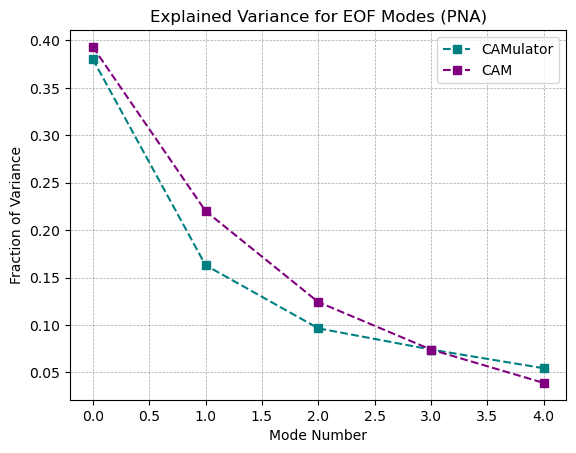

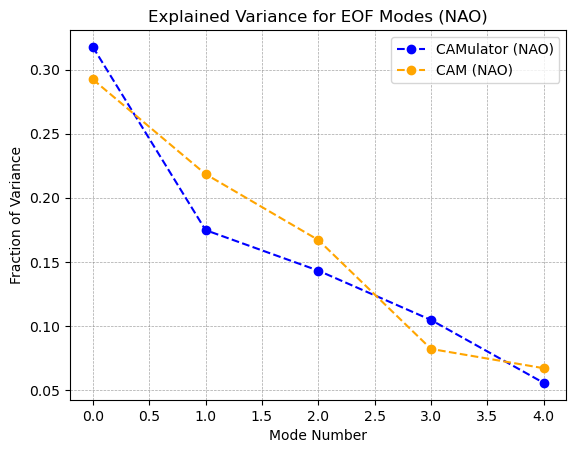

plotting


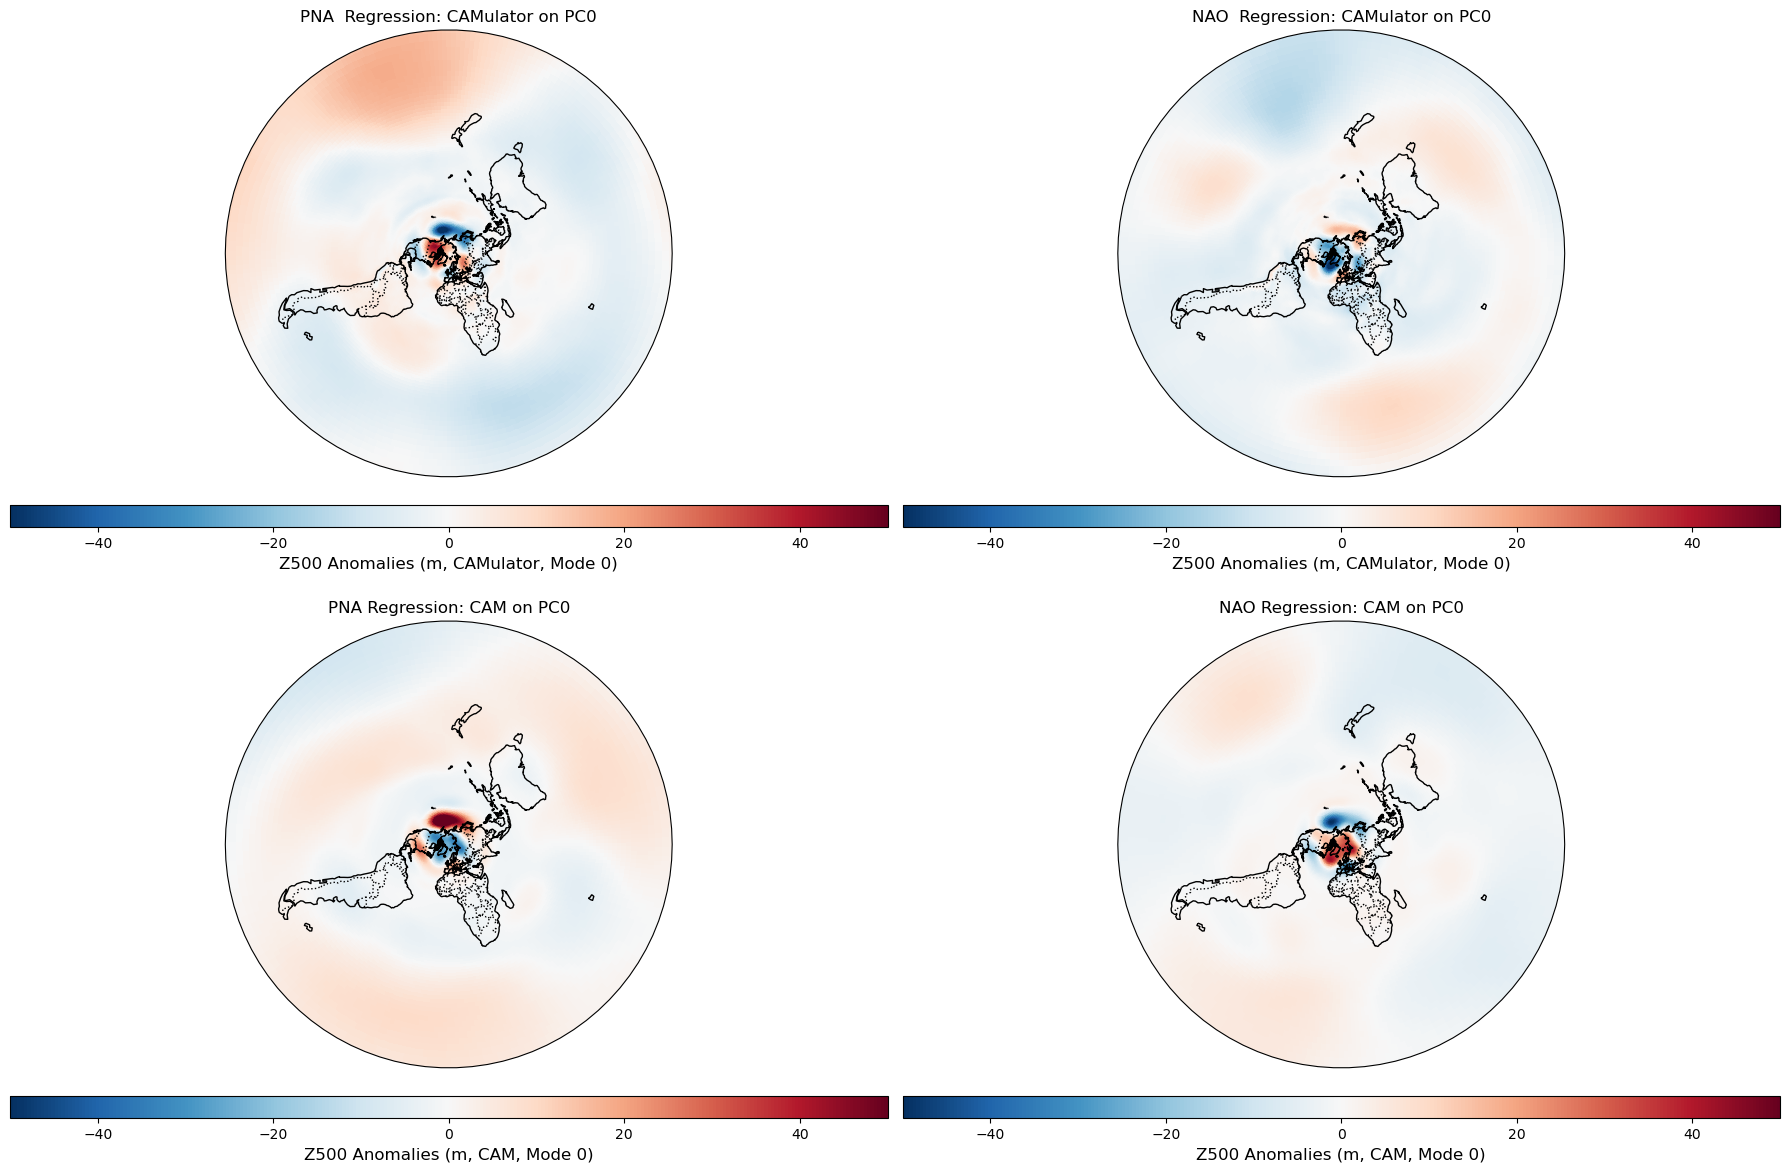

In [6]:

mons = [12, 1, 2]  # Months for DJF

# Step 1: Select the winter months (Dec, Jan, Feb) and spatial slice for DSall
print('one')
# Group data into winter seasons by averaging over Dec-Jan-Feb for each year
# Latitude weighting is applied to capture spherical influences
DS_winter = DSall.resample(time='QS-DEC').mean().where(DSall['time'].dt.month.isin(mons), drop=True).sel(latitude=slice(20, 85), longitude=slice(120, 300))

# Extract the geopotential height at 500 hPa and remove the time mean
DSwtot = DS_winter['Z_PRES'].sel(pressure=500).load()
DSwtota = DSwtot - DSwtot.mean('time')

# Step 2: Calculate weights based on cosine of latitude
coslat = np.cos(np.deg2rad(DSwtota.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]  # Expand dimensions to align with dataset

# Step 3: Perform EOF analysis for PNA extraction
# EOF patterns are computed for the domain (20-85°N, 120°E-120°W)
solver1 = Eof(DSwtota, weights=wgts)  # Create an EOF solver for the dataset
eof1 = solver1.eofsAsCorrelation(neofs=3)  # Extract the first 3 EOFs as correlations
pc1 = solver1.pcs(npcs=3, pcscaling=1)  # Get the first 3 PCs with scaling

# Step 4: Repeat the above for the CESM dataset
print('two')
DS_winter_CESM = DSall_CESM.resample(time='QS-DEC').mean().where(DSall_CESM['time'].dt.month.isin(mons), drop=True).sel(latitude=slice(20, 85), longitude=slice(120, 300))

DSwtot_CESM = DS_winter_CESM['Z_PRES'].sel(pressure=500).load()
DSwtota_CESM = DSwtot_CESM - DSwtot_CESM.mean('time')

coslat = np.cos(np.deg2rad(DSwtota_CESM.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]

solver2 = Eof(DSwtota_CESM, weights=wgts)
eof2 = solver2.eofsAsCorrelation(neofs=3)
pc2 = solver2.pcs(npcs=3, pcscaling=1)

# Step 5: Add NAO Analysis
# NAO domain: 20-80°N, 90°W-40°E
DS_nao = DSall.sel(latitude=slice(20, 88), longitude=((DSall.longitude >= 270) | (DSall.longitude <= 40)))
DS_nao_CESM = DSall_CESM.sel(latitude=slice(20, 88), longitude=((DSall_CESM.longitude >= 270) | (DSall_CESM.longitude <= 40)))

DS_nao = DS_nao.resample(time='QS-DEC').mean().where(DS_nao['time'].dt.month.isin(mons), drop=True)
DS_nao_CESM = DS_nao_CESM.resample(time='QS-DEC').mean().where(DS_nao_CESM['time'].dt.month.isin(mons), drop=True)

DS_nao_z500 = DS_nao['Z_PRES'].sel(pressure=500) - DS_nao['Z_PRES'].sel(pressure=500).mean('time')
DS_nao_CESM_z500 = DS_nao_CESM['Z_PRES'].sel(pressure=500) - DS_nao_CESM['Z_PRES'].sel(pressure=500).mean('time')

# Fix for applying weights in the Eof solver
latitude_weights = np.sqrt(np.cos(np.deg2rad(DS_nao_z500['latitude'].values)))
weights = np.broadcast_to(latitude_weights[:, np.newaxis], DS_nao_z500.shape[1:])

solver_nao = Eof(DS_nao_z500, weights=weights)
solver_nao_CESM = Eof(DS_nao_CESM_z500, weights=weights)

nao_pc1 = solver_nao.pcs(npcs=1, pcscaling=1)  # Leading EOF for NAO
nao_pc1_CESM = solver_nao_CESM.pcs(npcs=1, pcscaling=1)

# Step 6: Plot explained variance for both datasets
solver1.varianceFraction(neigs=5).plot(color='teal', linestyle='--', marker='s', label='CAMulator')
solver2.varianceFraction(neigs=5).plot(color='purple', linestyle='--', marker='s', label='CAM')
plt.title("Explained Variance for EOF Modes (PNA)")
plt.xlabel("Mode Number")
plt.ylabel("Fraction of Variance")
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

solver_nao.varianceFraction(neigs=5).plot(color='blue', linestyle='--', marker='o', label='CAMulator (NAO)')
solver_nao_CESM.varianceFraction(neigs=5).plot(color='orange', linestyle='--', marker='o', label='CAM (NAO)')
plt.title("Explained Variance for EOF Modes (NAO)")
plt.xlabel("Mode Number")
plt.ylabel("Fraction of Variance")
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

print('plotting')
# Step 7: Regression Analysis for NAO
fig, axes = plt.subplots(2, 2, figsize=(18, 12), subplot_kw={"projection": ccrs.NorthPolarStereo()})
loop = 0
for mode, pc_nao, pc_nao_CESM, solver, title_suffix in zip([0, 0], [pc1, nao_pc1], [pc2, nao_pc1_CESM], [[solver1, solver2], [solver_nao, solver_nao_CESM]], ["PNA","NAO"]):

    # Flatten spatial dimensions for regression
    DS_nao_flat =  DSall.resample(time='QS-DEC').mean().where(DSall['time'].dt.month.isin(mons), drop=True).stack(space=("latitude", "longitude"))['Z_PRES'].sel(pressure=500)
    DS_nao_CESM_flat = DSall_CESM.resample(time='QS-DEC').mean().where(DSall_CESM['time'].dt.month.isin(mons), drop=True).stack(space=("latitude", "longitude"))['Z_PRES'].sel(pressure=500)


    # Regression coefficients for NAO
    regression_coeffs_nao = np.dot(DS_nao_flat.values.T, pc_nao[:, mode]) / np.dot(pc_nao[:, mode], pc_nao[:, mode])
    regression_coeffs_nao_CESM = np.dot(DS_nao_CESM_flat.values.T, pc_nao_CESM[:, mode]) / np.dot(pc_nao_CESM[:, mode], pc_nao_CESM[:, mode])

    # Reshape coefficients back to spatial dimensions
    regression_map_ds = regression_coeffs_nao.reshape(DSall["latitude"].size, DSall["longitude"].size)
    regression_map_cesm = regression_coeffs_nao_CESM.reshape(DSall_CESM["latitude"].size, DSall_CESM["longitude"].size)

    # Apply spatial smoothing using Gaussian filter
    smoothed_map_ds = gaussian_filter(regression_map_ds, sigma=1)  # Adjust sigma for smoothing level
    smoothed_map_cesm = gaussian_filter(regression_map_cesm, sigma=1)

    # Plot regression map for DS_winter
    ax = axes[0, loop]
    im = ax.pcolormesh(
        DSall["longitude"], DSall["latitude"], smoothed_map_ds/9.81,
        transform=ccrs.PlateCarree(), cmap="RdBu_r", shading="auto", vmin=-50, vmax=50
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, edgecolor="black", alpha=0.5)
    cbar = plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.05, aspect=40)
    cbar.set_label(f"Z500 Anomalies (m, CAMulator, Mode {mode})", fontsize=12)
    ax.set_title(f"{title_suffix}  Regression: CAMulator on PC{mode}")

    # Plot regression map for DS_winter_CESM
    ax = axes[1, loop]
    im = ax.pcolormesh(
        DSall["longitude"], DSall["latitude"], smoothed_map_cesm/9.81,
        transform=ccrs.PlateCarree(), cmap="RdBu_r", shading="auto", vmin=-50, vmax=50
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, edgecolor="black", alpha=0.5)
    cbar = plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.05, aspect=40)
    cbar.set_label(f"Z500 Anomalies (m, CAM, Mode {mode})", fontsize=12)
    ax.set_title(f"{title_suffix} Regression: CAM on PC{mode}")
    loop+=1

plt.tight_layout()
plt.show()

plotting


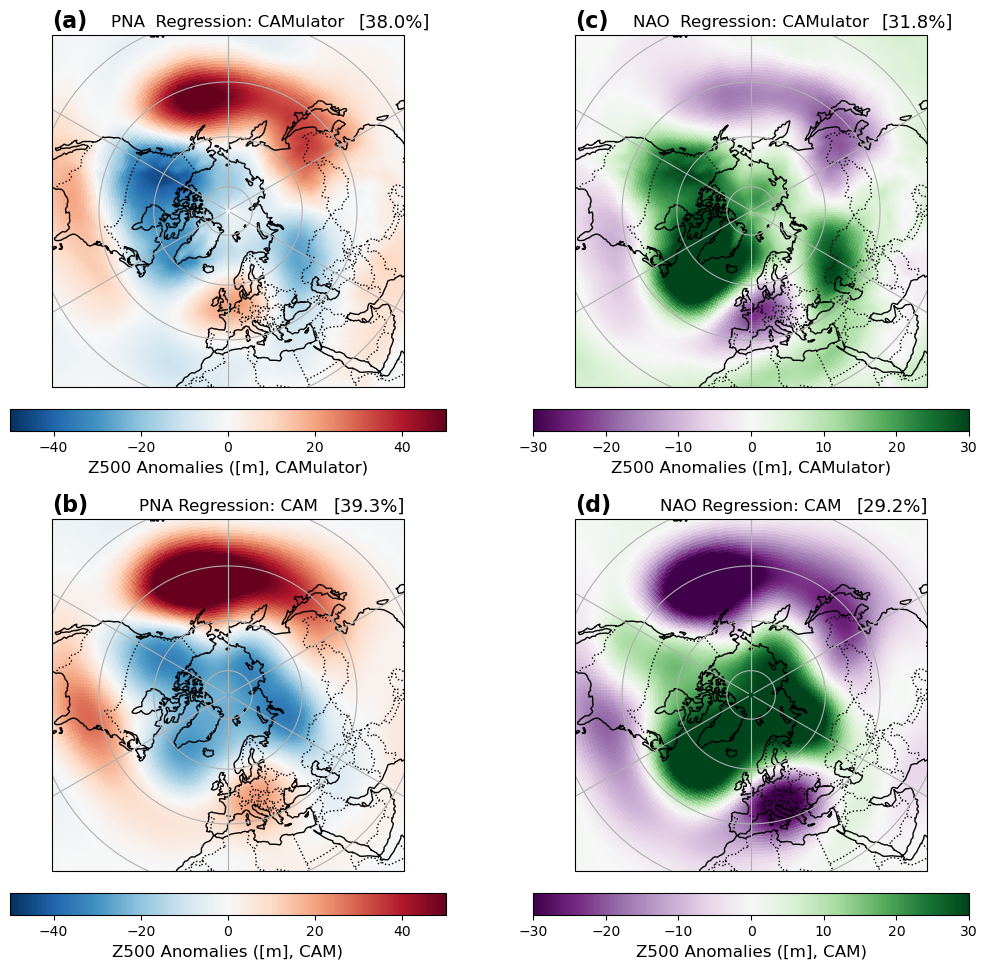

In [29]:
print('plotting')
# Step 7: Regression Analysis for NAO
fig, axes = plt.subplots(2, 2, figsize=(18, 12), subplot_kw={"projection": ccrs.NorthPolarStereo()})
plt.subplots_adjust(hspace=0.1, wspace=-0.1)
loop = 0
for mode, pc_nao, pc_nao_CESM, solver, title_suffix in zip([0, 0], [pc1, nao_pc1], [pc2, nao_pc1_CESM], [[solver1, solver2], [solver_nao, solver_nao_CESM]], ["PNA","NAO"]):

    # Flatten spatial dimensions for regression
    DS_nao_flat =  DSall.resample(time='QS-DEC').mean().where(DSall['time'].dt.month.isin(mons), drop=True).stack(space=("latitude", "longitude"))['Z_PRES'].sel(pressure=500)
    DS_nao_CESM_flat = DSall_CESM.resample(time='QS-DEC').mean().where(DSall_CESM['time'].dt.month.isin(mons), drop=True).stack(space=("latitude", "longitude"))['Z_PRES'].sel(pressure=500)


    # Regression coefficients for NAO
    regression_coeffs_nao = np.dot(DS_nao_flat.values.T, pc_nao[:, mode]) / np.dot(pc_nao[:, mode], pc_nao[:, mode])
    regression_coeffs_nao_CESM = np.dot(DS_nao_CESM_flat.values.T, pc_nao_CESM[:, mode]) / np.dot(pc_nao_CESM[:, mode], pc_nao_CESM[:, mode])

    # Reshape coefficients back to spatial dimensions
    regression_map_ds = regression_coeffs_nao.reshape(DSall["latitude"].size, DSall["longitude"].size)
    regression_map_cesm = regression_coeffs_nao_CESM.reshape(DSall_CESM["latitude"].size, DSall_CESM["longitude"].size)

    # Apply spatial smoothing using Gaussian filter
    smoothed_map_ds = gaussian_filter(regression_map_ds, sigma=1)  # Adjust sigma for smoothing level
    smoothed_map_cesm = gaussian_filter(regression_map_cesm, sigma=1)

    if loop == 0:
        cmap = 'RdBu_r'
    else:
        cmap = 'PRGn'
    # Plot regression map for DS_winter

    if title_suffix == 'NAO':
        vme = -30
        vma = 30
    else:
        vme = -50
        vma = 50
    ax = axes[0, loop]
    im = ax.pcolormesh(
        DSall["longitude"], DSall["latitude"], -1*smoothed_map_ds/9.81,
        transform=ccrs.PlateCarree(), cmap=cmap, shading="auto", vmin=vme, vmax=vma
    )
    ax.coastlines()
    ax.set_extent([-180, 180, 25, 90], crs=ccrs.PlateCarree())
    ax.gridlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, edgecolor="black", alpha=0.5)
    cbar = plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.05, aspect=20, shrink=0.5)
    cbar.set_label(f"Z500 Anomalies ([m], CAMulator)", fontsize=12)
    ax.set_title(f"{title_suffix}  Regression: CAMulator")
    if loop == 0:
        ax.text(0.0, 1.02, "(a)", transform=ax.transAxes, fontsize=16, fontweight="bold")
        ax.text(0.87, 1.02, f"[{(solver1.varianceFraction(neigs=1).values[0]*100):.1f}%]", transform=ax.transAxes, fontsize=13)
    if loop == 1:
        ax.text(0.0, 1.02, "(c)", transform=ax.transAxes, fontsize=16, fontweight="bold")
        ax.text(0.87, 1.02, f"[{(solver_nao.varianceFraction(neigs=1).values[0]*100):.1f}%]", transform=ax.transAxes, fontsize=13)

    # Plot regression map for DS_winter_CESM
    ax = axes[1, loop]
    im = ax.pcolormesh(
        DSall["longitude"], DSall["latitude"], smoothed_map_cesm/9.81,
        transform=ccrs.PlateCarree(), cmap=cmap, shading="auto", vmin=vme, vmax=vma
    )
    ax.coastlines()
    ax.set_extent([-180, 180, 25, 90], crs=ccrs.PlateCarree())
    ax.gridlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, edgecolor="black", alpha=0.5)
    cbar = plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.05, aspect=20, shrink=0.5)
    cbar.set_label(f"Z500 Anomalies ([m], CAM)", fontsize=12)
    ax.set_title(f"{title_suffix} Regression: CAM")

    if loop == 0:
        ax.text(0.0, 1.02, "(b)", transform=ax.transAxes, fontsize=16, fontweight="bold")
        ax.text(0.8, 1.02, f"[{(solver2.varianceFraction(neigs=1).values[0]*100):.1f}%]", transform=ax.transAxes, fontsize=13)
        # print(solver_nao.varianceFraction(neigs=1).values[0])
        # print(solver_nao_CESM.varianceFraction(neigs=1).values[0])
    if loop == 1:
        ax.text(0.0, 1.02, "(d)", transform=ax.transAxes, fontsize=16, fontweight="bold")
        ax.text(0.8, 1.02, f"[{(solver_nao_CESM.varianceFraction(neigs=1).values[0]*100):.1f}%]", transform=ax.transAxes, fontsize=13)
        
    loop+=1
plt.subplots_adjust(hspace=0.1, wspace=-0.4)
fig.savefig('NAO_PNA_Fig.png',dpi=250, bbox_inches='tight')
plt.show()

In [31]:
ls /glade/derecho/scratch/wchapman/archive/

b.e21.f09_g17.CNTRL2.1.5_001/           f.e21.DAcompset.adjust_zm_017/
b.e21.f09_g17.CNTRL2.1.5_002/           f.e21.DAcompset.adjust_zm_018/
b.e21.f09_g17.nudge_extrop.2.1.5/       f.e21.DAcompset.adjust_zm_019/
b.e21.f09_g17.nudge_extrop.2.1.5_001/   f.e21.DAcompset.adjust_zm_020/
b.e.FTORCH_CNTRL_0002/                  f.e21.DAcompset.adjust_zm_021/
b.e.FTORCH_fullCNN_0007/                f.e21.DAcompset.adjust_zm_022/
b.e.FTORCH_fullCNN_0010/                f.e21.DAcompset.adjust_zm_023/
b.e.FTORCH_fullCNN_0011/                f.e21.DAcompset.adjust_zm_024/
b.e.FTORCH_fullCNNfa_0002/              f.e21.DAcompset.adjust_zm_025/
b.e.FTORCH_fullCNNfa_0003/              f.e21.DAcompset.adjust_zm_026/
b.e.FTORCH_fullCNNfa_0004/              f.e21.DAcompset.sppt_stochai_CNTRL/
b.e.FTORCH_fullCNNfa_0006/              f.e21.REPLAY/
f.e21.CREDIT_climate/                   f.e21.REPLAY_will/
f.e21.CREDIT_climate_F2000/             f.e21.REPLAY_will02/
f.e21.CREDIT_climate_F2000_2k/          